# Parsing PC-SUDS with Python

PC-SUDS Tools (Work in Progress)

Utilities for reading, parsing, and converting PC-SUDS waveform files produced by SRC / Seismology Research Centre digitizers (EchoPro, Waves, etc). PC-SUDS is a loosely specified, binary format containing:

STATIONCOMP (ID 5) — station/channel metadata
DESCRIPTRACE (ID 7) — waveform blocks
COMMENT (ID 20) — recorder/sensor/system metadata
FEATURE (ID 10) — analyst picks (rare and poorly documented)
⸻

Goals

Extract waveforms and channel info and convert to Obspy Streams
Extract reliable basic station metadata from PC-SUDS (network, station, location, lat/lon/elev, channels, units, polarity, etc).
Extract recorder-level information (sensitivity, gain, sensor info) where available.
Identify and decode manual picks (FEATURE blocks) for P, S, and other phase types.
⸻

What Works Today

✅ Metadata Extraction

Full parsing of STATIONCOMP (5) and DESCRIPTRACE (7) blocks
Extraction of basic channel info incl: channel code, units, sensor type, atod gain, station coordinates and network/station/location codes
basic station information is available for multi-station files (each station gets its own metadata block)
✅ Recorder Metadata (First Pass)

Station recorder and sensor info extracted via COMMENT structs
Recognised issue: COMMENT blocks may be global, not per-station) (active area of investigation)
⸻

Known Issues / Current Limitations

FEATURE parsing (picks) not fully generalised, Works for simple cases; multi-station/multi-pick files unresolved.

Recorder metadata not yet correctly attributed per station, Multiple stations in one SUDS file may each have separate recorder info, but COMMENT blocks are not yet mapped reliably.

---

The following are working notes - some of this information may not be correct!

---

## 1. **SUDS File Structure (EchoPro / Gecko)**

Every SUDS block begins with a **12-byte STRUCTAG**:

| Bytes | Meaning |
|------|---------|
| 0 | `'S'` sync |
| 1 | `'6'` machine ID |
| 2–3 | struct ID (`uint16`) |
| 4–7 | struct length (`uint32`) |
| 8–11 | data length (`uint32`) |

A full block looks like:

```
[STRUCTAG][STRUCT_BODY][DATA_BODY]
```

Based on multiple real-world files we’ve inspected — both raw `.seismosphere.sud` files and hand-picked `.pick.sud` variants — the following struct types occur consistently:

| ID  | Struct Type      | Notes |
|-----|------------------|-------|
| **5**  | `STATIONCOMP`     | One per component. Always present. |
| **7**  | `DESCRIPTRACE`    | One per component. Contains the trace + waveform samples. |
| **20** | `COMMENT`          | One per component. Recorder metadata (SensorType, Sensitivity, OperatorTime, etc). |
| **10** | `FEATURE`          | **Confirmed present when picks exist.** One FEATURE struct per pick (P/S/others). |
| **31** | `DESC` / `DESCRIPHDR` | Appears after each STATIONCOMP. Contains calibration/scaling info. |
| **32** | `FREQUENCY` / `FREQAMP` | Rare but observed at end of some files. Not related to picks. |


---

## 2. **Where Metadata Actually Lives**

### ✔ A. STATIONCOMP (ID = 5) — the main metadata block

This contains:

- latitude / longitude / elevation  
- component code  
- channel number  
- sensor type (`v`, `a`, etc.)  
- data type (`i`, `l`, `f`)  
- data units  
- polarity  
- **A/D gain** (`atod_gain`)  
- **start epoch** (effective time)  

This is the **correct** source for station and channel identity.

### Important  

STATIONCOMP contains **A/D gain**, but *not* the recorder’s “counts per volt” calibration and *not* the sensor’s volts-per-unit sensitivity.  Those _apparently_ live outside the SUDS struct system

---

### ✔ B. DESCRIPTRACE (ID = 7) — waveform header + waveform data

We now know that the DESCRIPTRACE struct reliably contains:

- `begintime` (converted from FLOAT64 → epoch ms → epoch seconds)  
- `length` – exact number of samples  
- `rate` – the **correct sampling rate**  
- `datatype` – `'i'`, `'l'`, `'2'`, `'f'`  
- waveform min/max values  
- some gain correction floats  
- number of clipped samples  
- and then the **raw sample array**

### Why DESCRIPTRACE is essential

It provides **the correct:**

- start time  
- sample rate  
- number of samples  

and replaces the old “assume 60-second files” logic completely.

---

### ✔ C. COMMENT (ID = 20)

EchoPro writes rich text blocks, e.h. :

```
DataLogger=Echo Pro
Battery Voltage=10.76
SensorA=Guralp CMG-6T-1
SensorASerial=66532
SensorB=Guralp CMG-5T-2g
...
```

This is valuable operational metadata, but *not* response information.

---

## 3. **Recorder & Sensor Sensitivity Are Not in Any SUDS Struct**

This is the biggest practical insight from the reverse-engineering effort.

| Quantity | Where it actually lives |
|---------|--------------------------|
| **Recorder sensitivity (counts per volt)** | float32 @ **absolute offset 156** |
| **Sensor sensitivity (volts per unit)** | float32 @ **absolute offset 176** |
| **Neither belongs to any SUDS struct** | ✔ correct |

Examples found in real files:

### Recorder sensitivity
- Gecko: **419430.4**  
- EchoPro: **838860.8**

### Sensor sensitivity
- HML1 accelerometer: **1010.0**  
- LOCU velocimeter: **2400.0**  
- STBK accelerometer: **750.0**

These values were stable across many files.

---

## 4. **Waveform Extraction (Final, Correct Logic)**

We now use:

- **DESCRIPTRACE.rate** → sample rate  
- **DESCRIPTRACE.length** → number of samples  
- **STATIONCOMP.start_epoch** → start time  
- **STATIONCOMP.metadata** → channel identity  
- **raw `len_data`** → bytes to read  
- **datatype** → sample width  

This is robust for all tested digitizers and file variants.

---

## 5. where pick information actually lives

All seismic arrival picks (P, S, I-P, etc.) are stored in **struct ID 10 (FEATURE)**.  
Each FEATURE struct contains:

- `obs_phase` — phase number encoded per SudsArrivalNumbers (P, S, etc.)
- `onset`
- `direction` (first motion)
- `sig_noise`
- `data_source` (`i`, `a`, `d`, etc.)
- `tim_qual`
- `amp_qual`
- `ampunits`
- `gain_range`
- **`time` — arrival time, stored as MS_TIME (microseconds since epoch)**
- `amplitude`
- `period`
- **`time_of_pick` — ST_TIME (ms since epoch)**
- `pick_authority`
- `pick_reader`

This structure matches the SRC Java implementation exactly and is now the authoritative source for decoding picks.

## 6. **Summary**

- Modern digitizers produce a **minimal**, consistent subset of SUDS.
- Only three struct types appear:
  - **STATIONCOMP (ID 5)** — metadata  
  - **DESCRIPTRACE (ID 7)** — waveform header + samples  
  - **COMMENT (ID 20)** — text metadata  
- Recorder and sensor sensitivities live **outside** all structs, at fixed offsets.
- DESCRIPTRACE gives correct sample rate, correct sample count, and correct start time.
- STATIONCOMP gives correct channel/station metadata.
- Result: a fully functional, reliable PC-SUDS → MiniSEED converter in Python.

This gives us a transparent, reproducible extraction workflow — and replaces the often-misleading Java code with a clean, modern implementation.

In [5]:
import struct
import numpy as np
from obspy import Trace, Stream, UTCDateTime
from dataclasses import dataclass, field


In [6]:



# ============================================================
# 1. STATIONCOMP (unchanged from your "locked in" version)
# ============================================================
def parse_stationcomp_struct(raw, station_to_loc=None):
    """
    Parse a SUDS_STATIONCOMP struct of length 108 bytes
    (STATIDENT + STATIONCOMP guts + LONGIDENT) as per SRC Java.

    Returns a metadata dict with keys:
        network, station, location, channel_name, channel_number,
        component_char, data_type, start_epoch, latitude, longitude,
        elevation, atod_gain, sensor_type, data_units, polarity.
    """
    if len(raw) != 108:
        raise ValueError(f"Expected 108 bytes for STATIONCOMP, got {len(raw)}")

    # --- STATIDENT (0–11) ---
    statident = raw[0:12]
    net_short = statident[0:4].decode("ascii", errors="ignore").strip("\x00")
    sta_short = statident[4:9].decode("ascii", errors="ignore").strip("\x00")
    comp_char = statident[9:10].decode("ascii", errors="ignore")

    # --- STATIONCOMP guts (12–75, 64 bytes) ---
    sc = raw[12:76]

    lat = struct.unpack("<d", sc[4:12])[0]
    lon = struct.unpack("<d", sc[12:20])[0]
    elev = struct.unpack("<f", sc[20:24])[0]

    sensor_type = sc[31:32].decode("ascii", errors="ignore")
    data_type = sc[32:33].decode("ascii", errors="ignore")   # 'i', 'l', '2', 'f', ...
    data_units = sc[33:34].decode("ascii", errors="ignore")
    polarity = sc[34:35].decode("ascii", errors="ignore")

    channel_num = struct.unpack("<h", sc[48:50])[0]
    atod_gain = struct.unpack("<h", sc[50:52])[0]

    effective_val = struct.unpack("<i", sc[52:56])[0]
    # These files use seconds since Unix epoch
    if 1_000_000_000 < effective_val < 2_200_000_000:
        start_epoch = effective_val
    else:
        start_epoch = None

    # --- LONGIDENT (76–107, 32 bytes) ---
    li = raw[76:108]
    net_long = li[0:8].decode("ascii", errors="ignore").strip("\x00")
    sta_long = li[8:24].decode("ascii", errors="ignore").strip("\x00")
    comp_long = li[24:32].decode("ascii", errors="ignore").strip("\x00")

    # Prefer LONGIDENT if present
    network = net_long or net_short
    station = sta_long or sta_short
    channel_name = comp_long or comp_char  # 'CHE', 'CHZ', 'CHN', 'c01', …

    # Location code: SUDS has none → use mapping, else '00'
    if station_to_loc is not None and station in station_to_loc:
        location = station_to_loc[station]
    else:
        location = "00"

    return {
        "network": network,
        "station": station,
        "location": location,
        "channel_name": channel_name,
        "channel_number": channel_num,
        "component_char": comp_char,
        "data_type": data_type,
        "start_epoch": start_epoch,
        "latitude": lat,
        "longitude": lon,
        "elevation": elev,
        "atod_gain": atod_gain,
        "sensor_type": sensor_type,
        "data_units": data_units,
        "polarity": polarity,
    }


# ============================================================
# 2. DESCRIPTRACE parser (uses layout from Java + your hexdump)
# ============================================================
def _parse_descriptrace_struct(raw):
    """
    Parse SUDS_DESCRIPTRACE "guts" *after* STATIDENT.

    Layout inside the struct (after 12-byte STATIDENT):

      double begintime       (8 bytes)  [seconds since epoch in your files]
      short  localtime       (2)
      char   datatype        (1)        'i', 'l', '2', 'f'
      char   descriptor      (1)
      short  digi_by         (2)
      short  processed       (2)
      int    length          (4)        # samples
      float  rate            (4)        Hz
      float  mindata         (4)
      float  maxdata         (4)
      float  avenoise        (4)
      int    numclip         (4)
      double time_correct    (8)
      float  rate_correct    (4)

    We only actually *need*:
      begintime, datatype, length, rate
    """
    if len(raw) < 12 + 8 + 2 + 1 + 1 + 2 + 2 + 4 + 4:
        raise ValueError("DESCRIPTRACE struct too short")

    pos = 12  # skip STATIDENT

    begintime_sec = struct.unpack_from("<d", raw, pos)[0]
    pos += 8

    localtime = struct.unpack_from("<h", raw, pos)[0]
    pos += 2

    datatype = struct.unpack_from("<c", raw, pos)[0].decode("ascii", errors="ignore")
    pos += 1

    descriptor = struct.unpack_from("<c", raw, pos)[0].decode("ascii", errors="ignore")
    pos += 1

    digi_by = struct.unpack_from("<h", raw, pos)[0]
    pos += 2

    processed = struct.unpack_from("<h", raw, pos)[0]
    pos += 2

    length = struct.unpack_from("<i", raw, pos)[0]
    pos += 4

    rate = struct.unpack_from("<f", raw, pos)[0]
    pos += 4

    # We could read the rest, but we don't need it here.

    return {
        "begintime_sec": begintime_sec,
        "datatype": datatype,
        "length": length,
        "rate": rate,
        "localtime": localtime,
        "digi_by": digi_by,
        "processed": processed,
        "descriptor": descriptor,
    }


def parse_instrument_struct(struct_bytes):
    """
    Parse SUDS_INSTRUMENT (ID=10).
    Returns dict with instrument response parameters.
    """
    return {}


def parse_phasepick_struct(struct_bytes):
    """
    Parse SUDS_PHS (ID=20).
    Returns dict with station, channel, pick time, phase type, residual, etc.
    """
    return {}


def parse_study_struct(struct_bytes):
    """
    Parse SUDS_STUDY (ID=27).
    Returns dict with study/project information.
    """
    return {}


def parse_longident_struct(struct_bytes):
    """
    Parse SUDS_LONGIDENT (ID=31).
    Extended station ID.
    """
    return {}


def parse_hypo_struct(struct_bytes):
    """
    Parse SUDS_HYPO (ID=32).
    Returns dict:
        {
          "origin_time": ...,
          "latitude": ...,
          "longitude": ...,
          "depth_km": ...,
          "magnitude": ...,
          "errors": {...}
        }
    """
    return {}


In [7]:

# ============================================================
# 3. Waveform extraction — now using DESCRIPTRACE.rate/length
# ============================================================
def extract_waveforms_with_metadata(path, station_to_loc=None):
    """
    Extract all waveforms from a SUDS file and attach metadata derived
    from STATIONCOMP + DESCRIPTRACE.

    Returns a list of dicts with keys:
        network, station, location, channel,
        start_epoch, samprate, latitude, longitude, elevation, data (np.float32).
    """
    waves = []
    meta = None  # last STATIONCOMP for pairing

    with open(path, "rb") as f:
        while True:
            tag_raw = f.read(12)
            if len(tag_raw) < 12:
                break

            sync, mach, id_struct, len_struct, len_data = struct.unpack("<ccHII", tag_raw)
            if sync != b"S" or mach != b"6":
                raise RuntimeError(f"Bad SUDS tag sync/machine in {path}")

            struct_bytes = f.read(len_struct)
            data_bytes = f.read(len_data) if len_data > 0 else b""

            # --- STATIONCOMP (metadata per channel) ---
            if id_struct == 5:
                try:
                    meta = parse_stationcomp_struct(struct_bytes, station_to_loc=station_to_loc)
                except Exception:
                    meta = None
                continue

            # --- DESCRIPTRACE (waveform header + samples) ---
            if id_struct == 7:
                if meta is None:
                    # No matching STATIONCOMP; skip waveform safely
                    continue

                # First try to parse DESCRIPTRACE header
                desc = None
                try:
                    desc = _parse_descriptrace_struct(struct_bytes)
                except Exception:
                    desc = None

                # Decide datatype
                if desc is not None and desc["datatype"] in ("i", "l", "2", "f"):
                    dt = desc["datatype"]
                else:
                    dt = meta["data_type"]

                # Map datatype -> bytes/sample, numpy dtype
                if dt == "i":
                    bps = 2
                    np_dt = "<i2"
                elif dt in ("l", "2"):
                    bps = 4
                    np_dt = "<i4"
                elif dt == "f":
                    bps = 4
                    np_dt = "<f4"
                else:
                    # Unknown type: skip this waveform
                    continue

                total_samples = len(data_bytes) // bps

                # Prefer DESCRIPTRACE.length if sane, else fall back to all bytes
                if desc is not None and 0 < desc["length"] <= total_samples:
                    nsamp = desc["length"]
                else:
                    nsamp = total_samples

                # Prefer DESCRIPTRACE.rate if sane, else derive from nsamp/duration if you want
                if desc is not None and desc["rate"] > 0:
                    samprate = float(desc["rate"])
                else:
                    # Fallback: crude guess (1-minute files). You can tweak if needed.
                    samprate = float(nsamp) / 60.0 if nsamp > 0 else 0.0

                # Read exactly nsamp samples
                nbytes = nsamp * bps
                data = np.frombuffer(data_bytes[:nbytes], dtype=np_dt).astype("float32")

                waves.append({
                # --- High-level waveform info ---
                "network": meta["network"],
                "station": meta["station"],
                "location": meta["location"],
                "channel": meta["channel_name"],     # ObsPy channel code
                "start_epoch": meta["start_epoch"],
                "samprate": samprate,
                "data": data,
            
                # --- Coordinates ---
                "latitude": meta["latitude"],
                "longitude": meta["longitude"],
                "elevation": meta["elevation"],
            
                # --- Channel-level metadata from STATIONCOMP ---
                "channel_number": meta["channel_number"],
                "component_char": meta["component_char"],
                "sensor_type": meta["sensor_type"],      # 'v', 'a', etc
                "data_type": meta["data_type"],          # 'i', 'l', '2', 'f'
                "data_units": meta["data_units"],        # usually 'd'
                "polarity": meta["polarity"],            # 'n' or 'r'
                "atod_gain": meta["atod_gain"],          # REAL value!
            })

            # All other struct types are ignored here

    return waves


# ============================================================
# 4. Stream builder (unchanged interface)
# ============================================================
def suds_file_to_stream(path, station_to_loc=None):
    """
    Parse a SUDS file and return an ObsPy Stream with one Trace per component.
    """
    waves = extract_waveforms_with_metadata(path, station_to_loc=station_to_loc)

    traces = []
    for w in waves:
        if w["start_epoch"] is None:
            raise RuntimeError(f"No valid start_epoch found for file {path}")

        tr = Trace(
            data=w["data"],
            header={
                "network": w["network"],
                "station": w["station"],
                "location": w["location"],
                "channel": w["channel"],
                "starttime": UTCDateTime(w["start_epoch"]),
                "sampling_rate": w["samprate"],
            },
        )
        traces.append(tr)

    return Stream(traces=traces)

## test of read stream

In [8]:
st = suds_file_to_stream("data/20251209_0450_LOCU.seismosphere.sud")
print(st)

3 Trace(s) in Stream:
VW.LOCU.00.CHE | 2025-12-09T04:50:00.000000Z - 2025-12-09T04:50:59.996000Z | 250.0 Hz, 15000 samples
VW.LOCU.00.CHN | 2025-12-09T04:50:00.000000Z - 2025-12-09T04:50:59.996000Z | 250.0 Hz, 15000 samples
VW.LOCU.00.CHZ | 2025-12-09T04:50:00.000000Z - 2025-12-09T04:50:59.996000Z | 250.0 Hz, 15000 samples


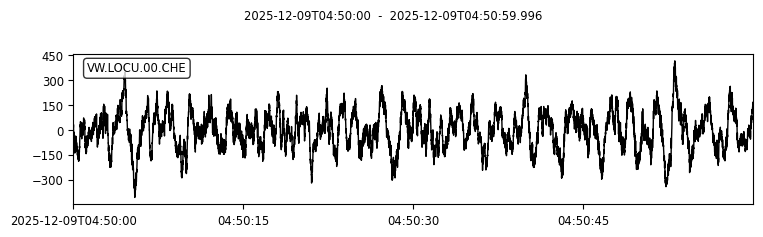

In [11]:
st[0].plot();

In [14]:
for tr in st:
    print(tr.stats['sampling_rate'])

250.0
250.0
250.0


In [15]:
#Multi station file
st = suds_file_to_stream("data/2025-12-05 0952 Mansfield Vic.dmx")
print(st)

63 Trace(s) in Stream:

S1.AUSMG.00.HHZ | 2025-12-05T09:51:59.000000Z - 2025-12-05T09:54:59.590000Z | 100.0 Hz, 18060 samples
...
(61 other traces)
...
OZ.FRTM.00.HHZ | 2025-12-05T09:52:00.000000Z - 2025-12-05T09:55:00.000000Z | 100.0 Hz, 18001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [17]:
for tr in st[0:5]:
    print(tr.stats['sampling_rate'])

100.0
40.0
100.0
40.0
100.0


## Metadata

In [19]:
from dataclasses import dataclass
import struct
from typing import List

@dataclass
class SudsComment:
    refer: int
    item: int
    length: int
    text: str
    struct_offset: int

def _decode_suds_comment(struct_buf: bytes, data_buf: bytes, offset: int) -> SudsComment:
    refer, item, length, unused = struct.unpack("<hhhh", struct_buf)
    text = data_buf.decode("utf-8", errors="replace")
    return SudsComment(refer, item, length, text, offset)

def parse_suds_comments(path: str) -> List[SudsComment]:
    COMMENT_ID = 20
    comments = []

    with open(path, "rb") as f:
        offset = 0
        while True:
            tag_raw = f.read(12)
            if len(tag_raw) < 12:
                break

            sync, machine, id_struct, len_struct, len_data = struct.unpack("<ccHII", tag_raw)
            if sync != b"S" or machine != b"6":
                break

            struct_buf = f.read(len_struct)
            data_buf = f.read(len_data) if len_data else b""

            if id_struct == COMMENT_ID:
                comments.append(
                    _decode_suds_comment(struct_buf, data_buf, offset)
                )

            offset += 12 + len_struct + len_data

    return comments


def read_float32_at_offset(path, offset):
    """
    Read a little-endian float32 from absolute byte offset in a file.
    Returns the float value or None if out of range.
    """
    with open(path, "rb") as f:
        f.seek(0, 2)
        size = f.tell()
        if offset + 4 > size:
            return None
        f.seek(offset)
        data = f.read(4)
    return struct.unpack("<f", data)[0]


def suds_file_metadata(path, station_to_loc=None):
    """
    Multi-station SUDS metadata.
    Returns:
    {
      "stations":  { key → station metadata },
      "recorders": { key → recorder metadata }
    }
    """
    # ---- Global recorder fallbacks ----
    global_recorder_sens = read_float32_at_offset(path, 156)
    global_sensor_sens   = read_float32_at_offset(path, 176)

    comments = parse_suds_comments(path)
    comment  = comments[0] if comments else None

    # ---- Waveform + STATIONCOMP parsing ----
    waves = extract_waveforms_with_metadata(path, station_to_loc=station_to_loc)
    if not waves:
        raise RuntimeError("No STATIONCOMP/trace metadata found")

    from collections import defaultdict
    grouped = defaultdict(list)

    for w in waves:
        key = f"{w['network']}.{w['station']}.{w['location']}"
        grouped[key].append(w)

    stations  = {}
    recorders = {}

    for key, ws in grouped.items():
        w0 = ws[0]

        # ---- station metadata ----
        station_meta = {
            "network": w0["network"],
            "station": w0["station"],
            "location": w0["location"],
            "latitude_deg": w0["latitude"],
            "longitude_deg": w0["longitude"],
            "elevation_m": w0["elevation"],
            "channels": {}
        }

        for w in ws:
            station_meta["channels"][w["channel"]] = {
                "channel_number": w["channel_number"],
                "component": w["component_char"],
                "sensor_type": w["sensor_type"],
                "data_type": w["data_type"],
                "data_units": w["data_units"],
                "polarity": w["polarity"],
            }

        stations[key] = station_meta

        # ---- recorder metadata (safe extraction) ----
        recorder_sens = w0.get("recorder_sens", global_recorder_sens)
        sensor_sens   = w0.get("sensor_sens",   global_sensor_sens)
        atod_gain     = w0.get("atod_gain",     None)

        recorders[key] = {
            "recorder_sensitivity_counts_per_volt": recorder_sens,
            "sensor_sensitivity_volts_per_unit": sensor_sens,
            "atod_gain": atod_gain,
            "comment": comment,
        }

    return {
        "stations": stations,
        "recorders": recorders,
    }


In [20]:
single_station = suds_file_metadata("data/20251208_0500_HML1.seismosphere.sud")

In [21]:
single_station.keys()

dict_keys(['stations', 'recorders'])

In [22]:
single_station['stations']

{'AB.HML1.00': {'network': 'AB',
  'station': 'HML1',
  'location': '00',
  'latitude_deg': -34.403350830078125,
  'longitude_deg': 138.5888671875,
  'elevation_m': 73.0,
  'channels': {'c01': {'channel_number': 1,
    'component': 'e',
    'sensor_type': 'v',
    'data_type': 'i',
    'data_units': 'd',
    'polarity': 'n'},
   'c02': {'channel_number': 2,
    'component': 'n',
    'sensor_type': 'v',
    'data_type': 'i',
    'data_units': 'd',
    'polarity': 'n'},
   'c03': {'channel_number': 3,
    'component': 'v',
    'sensor_type': 'v',
    'data_type': 'i',
    'data_units': 'd',
    'polarity': 'n'}}}}

## metadata for multi -station suds

* Working for stations, 

* but not for recorders (not sure how to access the station level info)


In [23]:
multi_station = suds_file_metadata("data/2025-12-05 0952 Mansfield Vic.dmx")


In [24]:
multi_station['stations']['S1.AUSMG.00']

{'network': 'S1',
 'station': 'AUSMG',
 'location': '00',
 'latitude_deg': -36.416099548339844,
 'longitude_deg': 148.6083984375,
 'elevation_m': 951.0,
 'channels': {'HHZ': {'channel_number': 6,
   'component': 'Z',
   'sensor_type': 'v',
   'data_type': 'l',
   'data_units': 'd',
   'polarity': 'n'},
  'HHE': {'channel_number': 4,
   'component': 'E',
   'sensor_type': 'v',
   'data_type': 'l',
   'data_units': 'd',
   'polarity': 'n'},
  'HHN': {'channel_number': 5,
   'component': 'N',
   'sensor_type': 'v',
   'data_type': 'l',
   'data_units': 'd',
   'polarity': 'n'}}}

In [286]:
multi_station['stations']['OZ.KORUM.00']

{'network': 'OZ',
 'station': 'KORUM',
 'location': '00',
 'latitude_deg': -38.40644073486328,
 'longitude_deg': 145.85084533691406,
 'elevation_m': 354.0,
 'channels': {'HHE': {'channel_number': 39,
   'component': 'H',
   'sensor_type': 'v',
   'data_type': 'f',
   'data_units': 'd',
   'polarity': 'n'},
  'HHN': {'channel_number': 40,
   'component': 'H',
   'sensor_type': 'v',
   'data_type': 'f',
   'data_units': 'd',
   'polarity': 'n'},
  'HHZ': {'channel_number': 41,
   'component': 'H',
   'sensor_type': 'v',
   'data_type': 'f',
   'data_units': 'd',
   'polarity': 'n'}}}

In [287]:
multi_station['recorders']['AU.TOO.00']

{'recorder_sensitivity_counts_per_volt': 2465210112.0,
 'sensor_sensitivity_volts_per_unit': 1.0,
 'atod_gain': 1,
 'comment': SudsComment(refer=-32767, item=-32767, length=212, text='Battery Voltage=-1.0\nSupply Current=-1.0\nCharger Current=-1.0\nTotal Bytes=-1\nPercent Free=-1.0\nTemperature=-999.0\nSync=0.0\nSensorA=CMG-6TD,Guralp, CMG-6T, 30 s - 100 Hz, 2400,Guralp\nNormalizingFactor=1.00000e+00\n', struct_offset=72594)}

In [288]:
multi_station['recorders']['OZ.HOPM.00']

{'recorder_sensitivity_counts_per_volt': 2465210112.0,
 'sensor_sensitivity_volts_per_unit': 1.0,
 'atod_gain': 1,
 'comment': SudsComment(refer=-32767, item=-32767, length=212, text='Battery Voltage=-1.0\nSupply Current=-1.0\nCharger Current=-1.0\nTotal Bytes=-1\nPercent Free=-1.0\nTemperature=-999.0\nSync=0.0\nSensorA=CMG-6TD,Guralp, CMG-6T, 30 s - 100 Hz, 2400,Guralp\nNormalizingFactor=1.00000e+00\n', struct_offset=72594)}

multi_station['recorders']




In [279]:
multi_station['recorders']

{'S1.AUSMG.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'AU.TOO.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'OZ.CCRM.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'AU.GEXS.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'OZ.CDNM.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'OZ.WAMB.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'M8.MOGAR.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'S1.AUSSC.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'OZ.TOT.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'OZ.KORUM.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'AB.BEGA.00': {'comment': None, 'atod_gain_values': [1]},
 'OZ.FRTM.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'DU.S88P.00': {'comment': None, 'atod_gain_values': [1]},
 'OZ.BUCHN.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'AU.MILA.00': {'comment': None, 'atod_gain_values': [1, 1, 1]},
 'AU.MLBS.00': {'comment': None, '

# Picks / Phase arrivals



**My strategy here was to take a single station, add a single P pick, then compare files**

A brief summary for future investigation: 


1.	Identifying the FEATURE structures

* SUDS tag scanner correctly located the FEATURE structs (struct_id = 10).
* In the single-pick file there was exactly one FEATURE struct, at offset 121562 with length 80 bytes.
* These FEATURE blocks contain the arrival picks.
	
2.	Extracting the FEATURE payload

The FEATURE struct consists of:

* The statident block
* The longident block
* The actual FEATURE fields (the last 36 bytes)

The last 36 bytes correspond exactly to the field layout implemented in the SRC Java class SUDS_FEATURE.
	
    
    3.	Field ordering from the SRC Java source

The following order was confirmed as correct:

obs_phase (short)
onset (char)
direction (char)
sig_noise (short)
data_source (char)
tim_qual (char)
amp_qual (char)
ampunits (char)
gain_range (short)
time (double, arrival time in microseconds)
amplitude (float)
period (float)
time_of_pick (int)
pick_authority (short)
pick_reader (short)

This is exactly how the Java readGuts() method reads the struct.
	
4.	Correct identification of the P-wave

From the parsed bytes:
obs_phase = 0x0032 = 50 decimal.
Using SudsArrivalNumbers from the Java source, phase 50 corresponds to “P”.
This matched the viewer, confirming we correctly extracted the pick type.

5.	Correct extraction of the arrival time

The “time” field (the double) contained a value that corresponded to:
2025-12-09 04:50:25.425 UTC.
This was the exact time manually picked in the viewer.

This proves:

* We parsed the FEATURE struct correctly.
* We interpreted MS_TIME correctly.
* We extracted a valid, meaningful pick time.

6.	Other fields matched expectations

data_source was correct for an interactive/manual pick.
onset, amplitude, and period matched what the viewer produced for a simple P-only pick.
Amplitude values were sentinel defaults because no amplitude measurement was made.
	
7.	Conclusion for the single-pick case


a) Locate struct_id = 10 blocks.
b) Extract the 80-byte payload.
c) Split off the final 36 bytes as the FEATURE content.
d) Parse according to the Java SUDS_FEATURE field order.
e) Convert obs_phase into a phase label.
f) Convert arrival time into a UTC timestamp.
g) All values match the viewer output.

This provides a correct, stable baseline.

8.	What didn’t work (yet) in the multi-pick case

* Multiple FEATURE blocks appear per station, but their meaning needs to be disentangled.
* Some picks may not populate the arrival-time field, only the time_of_pick field.
* S-wave picks may use the same station ident but a different offset; their relationship is not yet mapped.
* Amplitude picks may not be encoded as FEATURE; they might live in a different struct type.
* The order of FEATURE structs may not correspond to P → S → amplitude, so you have to parse them by obs_phase, not by position.


⸻

In [178]:
from pathlib import Path

before_path = Path("data/20251209_0450_LOCU.seismosphere.sud")
after_path  = Path("data/20251209_0450_LOCU.pick.sud")

b0 = before_path.read_bytes()
b1 = after_path.read_bytes()

len(b0), len(b1)

(182511, 182552)

In [179]:
def find_diff_spans(a: bytes, b: bytes, max_spans=50):
    n = min(len(a), len(b))
    spans = []
    i = 0
    while i < n:
        if a[i] != b[i]:
            start = i
            while i < n and a[i] != b[i]:
                i += 1
            spans.append((start, i))
            if len(spans) >= max_spans:
                break
        else:
            i += 1
    return spans

diffs = find_diff_spans(b0, b1, max_spans=50)
len(diffs), diffs[:10]

(50,
 [(21, 22),
  (72, 73),
  (114, 115),
  (141, 142),
  (148, 149),
  (180, 183),
  (240, 241),
  (267, 268),
  (295, 297),
  (300, 301)])

In [180]:
def hexdump_block(buf: bytes, start: int, length: int = 128):
    start = max(start, 0)
    end = min(len(buf), start + length)
    offset = start
    while offset < end:
        chunk = buf[offset:end if offset+16 > end else offset+16]
        hex_part = " ".join(f"{b:02x}" for b in chunk)
        ascii_part = "".join(chr(b) if 32 <= b < 127 else "." for b in chunk)
        print(f"{offset:08x}  {hex_part:<47}  |{ascii_part}|")
        offset += 16

for idx, (start, end) in enumerate(diffs[:10]):  # first few regions
    print(f"\n=== DIFF BLOCK {idx} @ {start}–{end} (len={end-start}) ===\n")
    context_start = start - 32
    print("--- BEFORE ---")
    hexdump_block(b0, context_start, length=128)
    print("--- AFTER ---")
    hexdump_block(b1, context_start, length=128)


=== DIFF BLOCK 0 @ 21–22 (len=1) ===

--- BEFORE ---
00000000  53 36 05 00 6c 00 00 00 00 00 00 00 56 57 00 00  |S6..l.......VW..|
00000010  4c 4f 43 55 00 45 00 00 00 00 00 00 00 00 00 e0  |LOCU.E..........|
00000020  ac 2e 43 c0 00 00 00 60 67 37 62 40 00 00 09 43  |..C....`g7b@...C|
00000030  5f 00 4b 5f 80 01 5f 76 6c 64 6e 67 00 fe ff c6  |_.K_.._vldng....|
00000040  00 00 00 4b 00 fe ff c6 01 00 01 00 78 aa 37 69  |...K........x.7i|
00000050  00 00 00 00 00 00 00 00 56 57 00 00 00 00 00 00  |........VW......|
00000060  4c 4f 43 55 00 00 00 00 00 00 00 00 00 00 00 00  |LOCU............|
00000070  43 48 45 00 00 00 00 00 53 36 1f 00 72 00 00 00  |CHE.....S6..r...|
--- AFTER ---
00000000  53 36 05 00 6c 00 00 00 00 00 00 00 56 57 00 00  |S6..l.......VW..|
00000010  4c 4f 43 55 00 4e 00 00 00 00 00 00 00 00 00 e0  |LOCU.N..........|
00000020  ac 2e 43 c0 00 00 00 60 67 37 62 40 00 00 09 43  |..C....`g7b@...C|
00000030  5f 00 4b 5f 80 01 5f 76 6c 64 6e 67 00 fe ff c6  |_.K_.._vldng..

In [182]:
def list_tags(path):
    """
    Scan a SUDS file and return all tag structures:
    sync 'S', machine '6', struct_id, struct_length, data_length.
    """
    tags = []
    with open(path, "rb") as f:
        data = f.read()

    i = 0
    n = len(data)

    while i < n-12:
        # Look for 'S6'
        if data[i] == 0x53 and data[i+1] == 0x36:
            
            # Candidate tag location
            try:
                struct_id, struct_length, data_length = struct.unpack_from("<HII", data, i+2)
            except struct.error:
                i += 1
                continue

            # Sanity check: struct_length must be >= tag size
            if 0 < struct_length < 50000:
                tags.append({
                    "offset": i,
                    "struct_id": struct_id,
                    "struct_length": struct_length,
                    "data_length": data_length,
                })

                # Skip ahead: jump past tag + data (if declared sanely)
                jump = 12 + struct_length + data_length
                i += max(jump, 1)
                continue
        
        i += 1

    return tags

In [198]:
list_tags("data/20251209_0450_LOCU.pick.sud")

[{'offset': 0, 'struct_id': 5, 'struct_length': 108, 'data_length': 0},
 {'offset': 120, 'struct_id': 31, 'struct_length': 114, 'data_length': 0},
 {'offset': 246, 'struct_id': 7, 'struct_length': 96, 'data_length': 60000},
 {'offset': 60354, 'struct_id': 20, 'struct_length': 8, 'data_length': 407},
 {'offset': 60781, 'struct_id': 5, 'struct_length': 108, 'data_length': 0},
 {'offset': 60901, 'struct_id': 31, 'struct_length': 114, 'data_length': 0},
 {'offset': 61027, 'struct_id': 7, 'struct_length': 96, 'data_length': 60000},
 {'offset': 121135, 'struct_id': 20, 'struct_length': 8, 'data_length': 407},
 {'offset': 121562, 'struct_id': 10, 'struct_length': 80, 'data_length': 0},
 {'offset': 121654, 'struct_id': 5, 'struct_length': 108, 'data_length': 0},
 {'offset': 121774, 'struct_id': 31, 'struct_length': 114, 'data_length': 0},
 {'offset': 121900, 'struct_id': 7, 'struct_length': 96, 'data_length': 60000},
 {'offset': 182008, 'struct_id': 20, 'struct_length': 8, 'data_length': 407},

In [193]:
t_clean = list_tags("data/20251209_0450_LOCU.seismosphere.sud")
t_pick  = list_tags("data/20251209_0450_LOCU.pick.sud")

len(t_clean), len(t_pick)

(13, 16)

In [194]:
clean_offsets = {t["offset"] for t in t_clean}
pick_offsets  = {t["offset"] for t in t_pick}

new_offsets = sorted(pick_offsets - clean_offsets)
new_offsets

[60781,
 60901,
 61027,
 121135,
 121562,
 121654,
 121774,
 121900,
 182008,
 182435,
 182527,
 182619]

In [195]:
[tag for tag in t_pick if tag["offset"] in new_offsets]

[{'offset': 60781, 'struct_id': 5, 'struct_length': 108, 'data_length': 0},
 {'offset': 60901, 'struct_id': 31, 'struct_length': 114, 'data_length': 0},
 {'offset': 61027, 'struct_id': 7, 'struct_length': 96, 'data_length': 60000},
 {'offset': 121135, 'struct_id': 20, 'struct_length': 8, 'data_length': 407},
 {'offset': 121562, 'struct_id': 10, 'struct_length': 80, 'data_length': 0},
 {'offset': 121654, 'struct_id': 5, 'struct_length': 108, 'data_length': 0},
 {'offset': 121774, 'struct_id': 31, 'struct_length': 114, 'data_length': 0},
 {'offset': 121900, 'struct_id': 7, 'struct_length': 96, 'data_length': 60000},
 {'offset': 182008, 'struct_id': 20, 'struct_length': 8, 'data_length': 407},
 {'offset': 182435, 'struct_id': 10, 'struct_length': 80, 'data_length': 0},
 {'offset': 182527, 'struct_id': 10, 'struct_length': 80, 'data_length': 0},
 {'offset': 182619, 'struct_id': 32, 'struct_length': 45, 'data_length': 60}]

In [196]:
def parse_struct10_feature(data, offset):
    body = data[offset+12 : offset+12+80]
    
    statident = body[:16]
    rest = body[16:]

    fields = struct.unpack("<h c c h c c c c h d f f i h h", rest)

    return {
        "network": statident[0:2].decode("ascii", "ignore"),
        "station": statident[2:7].decode("ascii", "ignore"),
        "component": chr(statident[7]),
        "obs_phase": fields[0],
        "onset": fields[1].decode(),
        "direction": fields[2].decode(),
        "sig_noise": fields[3],
        "data_source": fields[4].decode(),
        "tim_qual": fields[5],
        "amp_qual": fields[6],
        "ampunits": fields[7],
        "gain_range": fields[8],
        "arrival_time": fields[9],    # MS_TIME
        "amplitude": fields[10],
        "period": fields[11],
        "time_of_pick": fields[12],   # ST_TIME
        "pick_authority": fields[13],
        "pick_reader": fields[14],
    }

In [197]:
import binascii

def read_struct10(data, offset, struct_length=80):
    header = data[offset : offset+12]
    payload = data[offset+12 : offset+12+struct_length]

    print("=== HEADER (12 bytes) ===")
    print(binascii.hexlify(header, sep=" ").decode())

    print("\n=== PAYLOAD (struct_id 10, length 80) ===")
    print(binascii.hexlify(payload, sep=" ").decode())

    return payload

# Load file
with open("data/20251209_0450_LOCU.pick.sud", "rb") as f:
    data = f.read()

payload = read_struct10(data, 182343)

=== HEADER (12 bytes) ===
0a 53 65 6e 73 6f 72 41 53 65 72 69

=== PAYLOAD (struct_id 10, length 80) ===
61 6c 3d 75 6e 6b 6e 6f 77 6e 0a 46 69 6c 74 65 72 20 30 2e 30 20 31 32 35 2e 30 0a 4e 6f 72 6d 61 6c 69 7a 69 6e 67 46 61 63 74 6f 72 3d 31 2e 30 30 30 30 30 65 2b 30 30 0a 53 65 6e 73 6f 72 53 65 6e 73 69 74 69 76 69 74 79 3d 30 2e 30 0a


In [189]:
payload = read_struct10(data, 182343)

=== HEADER (12 bytes) ===
53 36 0a 00 50 00 00 00 00 00 00 00

=== PAYLOAD (struct_id 10, length 80) ===
30 00 00 00 4c 4f 43 55 00 45 00 00 32 00 20 20 00 00 20 33 30 20 00 00 33 33 5b a4 ea 4d da 41 00 00 00 00 00 00 00 00 17 b9 38 69 5f 5f 5f 5f 30 00 00 00 00 00 00 00 4c 4f 43 55 00 00 00 00 00 00 00 00 00 00 00 00 43 48 45 00 00 00 00 00


In [190]:
import struct

def read_feature_at_tag(path, tag):
    """
    Read a single SUDS_FEATURE (struct_id=10) and print the raw arrival time.
    Assumes `tag` is one of the dicts returned by your list_tags().
    """
    assert tag["struct_id"] == 10, "Not a FEATURE struct"

    with open(path, "rb") as f:
        # 1. Seek to the start of this struct
        f.seek(tag["offset"])

        # 2. Read the 12-byte SUDS_STRUCTAG header ("S6", id, lengths, etc.)
        header = f.read(12)
        magic, struct_id, struct_len = struct.unpack("<2sH I", header[:8])
        # (You can print these if you want to sanity-check)

        # 3. Read the FEATURE payload
        payload_len = struct_len  # in your file this is 80
        payload = f.read(payload_len)

    # -------------------------------------------------------
    # NOW WE ARE IN THE FEATURE PAYLOAD
    # -------------------------------------------------------
    #
    # The tricky bit is the NamedSuds "name" blob at the front.
    # The *safe* thing to do is:
    #   - scan the payload for the first place where the FEATURE body
    #     looks valid: obs_phase (short), some chars, then a plausible double.
    #
    # This keeps us honest without assuming too much about NamedSuds.

    def try_parse_feature_body(start):
        body = payload[start:start+36]
        if len(body) < 36:
            return None

        obs_phase, onset, direction, sig_noise, \
        data_source, tim_qual, amp_qual, ampunits, \
        gain_range, time_val, amplitude, period, \
        time_of_pick, pick_authority, pick_reader = struct.unpack(
            "<hcc h cccc h d f f i h h", body
        )

        return {
            "start": start,
            "obs_phase": obs_phase,
            "onset": onset.decode("ascii", "ignore"),
            "direction": direction.decode("ascii", "ignore"),
            "data_source": data_source.decode("ascii", "ignore"),
            "tim_qual": tim_qual.decode("ascii", "ignore"),
            "amp_qual": amp_qual.decode("ascii", "ignore"),
            "ampunits": ampunits.decode("ascii", "ignore"),
            "sig_noise": sig_noise,
            "gain_range": gain_range,
            "time": time_val,
            "amplitude": amplitude,
            "period": period,
            "time_of_pick_raw": time_of_pick,
            "pick_authority_raw": pick_authority,
            "pick_reader_raw": pick_reader,
        }

    # Brute-force: slide over the payload and look for a *sane* time field
    candidates = []
    for start in range(0, len(payload) - 36):
        try:
            feat = try_parse_feature_body(start)
        except struct.error:
            continue
        if feat is None:
            continue

        # Very weak sanity check: time should be non-zero and not NaN/inf
        t = feat["time"]
        if 0 < abs(t) < 1e18:
            candidates.append(feat)

    print(f"Found {len(candidates)} candidate FEATURE bodies in this payload")
    for feat in candidates:
        print("---- CANDIDATE ----")
        print(f"start offset in payload: {feat['start']}")
        print(f"obs_phase: {feat['obs_phase']}")
        print(f"onset: {feat['onset']!r}, direction: {feat['direction']!r}")
        print(f"data_source: {feat['data_source']!r}")
        print(f"time (raw double): {feat['time']}")
        print(f"time_of_pick (raw int): {feat['time_of_pick_raw']}")

In [191]:
feature_tag = {
    "offset": 182343,
    "struct_id": 10,
    "struct_length": 80,
    "data_length": 0,
}

read_feature_at_tag("data/20251209_0450_LOCU.pick.sud", feature_tag)

Found 31 candidate FEATURE bodies in this payload
---- CANDIDATE ----
start offset in payload: 0
obs_phase: 48
onset: '\x00', direction: '\x00'
data_source: 'C'
time (raw double): 1.9446925070625807e-62
time_of_pick (raw int): 1104825834
---- CANDIDATE ----
start offset in payload: 1
obs_phase: 0
onset: '\x00', direction: 'L'
data_source: 'U'
time (raw double): 1.6516672368077707e-76
time_of_pick (raw int): 4315725
---- CANDIDATE ----
start offset in payload: 2
obs_phase: 0
onset: 'L', direction: 'O'
data_source: '\x00'
time (raw double): 1.2082293478490017e-153
time_of_pick (raw int): 16858
---- CANDIDATE ----
start offset in payload: 3
obs_phase: 19456
onset: 'O', direction: 'C'
data_source: 'E'
time (raw double): 4.502514859642823e-308
time_of_pick (raw int): 65
---- CANDIDATE ----
start offset in payload: 4
obs_phase: 20300
onset: 'C', direction: 'U'
data_source: '\x00'
time (raw double): 1.74856690950336e-310
time_of_pick (raw int): 0
---- CANDIDATE ----
start offset in payload: 5

In [192]:
from datetime import datetime, timezone, timedelta

arrival = 1765255825.425  # your value from the FEATURE

dt = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=arrival)
print(dt)

2025-12-09 04:50:25.425000+00:00


In [ ]:
dt = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=arrival)
print(dt)

## scratch

In [250]:
def suds_file_metadata(path, station_to_loc=None):
    """
    Clean consolidated metadata structure.
    Returns:
      {
        "recorder": { ... },
        "station": { ... }
      }
    """
    # ---- 1. Recorder-level values ----
    recorder_sens = read_float32_at_offset(path, 156)
    sensor_sens   = read_float32_at_offset(path, 176)
    comments      = parse_suds_comments(path)
    comment       = comments[0] if comments else None

    # ---- 2. Station + channel metadata ----
    waves = extract_waveforms_with_metadata(path, station_to_loc=station_to_loc)

    if not waves:
        raise RuntimeError("No STATIONCOMP/trace metadata found")

    # All channels have same station coordinates
    w0 = waves[0]

    station_meta = {
        "network": w0["network"],
        "station": w0["station"],
        "location": w0["location"],
        "latitude_deg": w0["latitude"],
        "longitude_deg": w0["longitude"],
        "elevation_m": w0["elevation"],
        "channels": {}
    }

    # Move atod_gain to recorder-level
    atod_gain = w0["atod_gain"]

    for w in waves:
        station_meta["channels"][w["channel"]] = {
            "channel_number": w["channel_number"],
            "component": w["component_char"],
            "sensor_type": w["sensor_type"],
            "data_type": w["data_type"],
            "data_units": w["data_units"],
            "polarity": w["polarity"],
        }

    return {
        "recorder": {
            "recorder_sensitivity_counts_per_volt": recorder_sens,
            "sensor_sensitivity_volts_per_unit": sensor_sens,
            "atod_gain": atod_gain,
            "comment": comment,
        },
        "station": station_meta,
    }